# Wrangling flow data

While it is convenient to use a package such as `cytofkit`, sometimes you need to further manipulate your data or experiement with a new clustering or visualization algorithm. In order to do so, it is necessary to know how to manuplate data "from first principles" using modern R syntax.

#### Load FCS file into FlowFrame 

While you can load FCS files into a FlowFrame using `flowCore`, it is quite strcit in data validatioan and might not work with processed FCS files. I find it easier to just use a regular data frame and manipullate it using `dplyr` and friends.

The [package description](https://www.bioconductor.org/packages/devel/bioc/vignettes/flowCore/inst/doc/HowTo-flowCore.pdf) for `flowCore` is quite old, and installation can be tricky, so we will just show a small example for completeness.

In [1]:
library(flowCore)
library(flowViz)


Attaching package: ‘flowCore’

The following object is masked from ‘package:base’:

    sort

Loading required package: lattice


In [2]:
path <- "data/AMJ_Costim_1.fcs"
x <- read.FCS(path, transformation=TRUE)
summary(x) 

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Blue B-A,Blue A-A,Violet H-A,Violet G-A,Red C-A,Red B-A,Red A-A,Green E-A,Green D-A,Green C-A,Green A-A,Time
Min.,24513.87,25008.00,63784.54,2524.86,2452.00,45908.73,-106.470,-128.700,-107.10000,-129.15,-122.850,-172.200,-273.000,-123.7600,-107.38,-218.40,-134.6800,0.1
1st Qu.,94507.53,73299.25,78180.40,40902.03,35993.00,72838.75,230.490,258.570,57.75000,1043.70,213.150,246.750,254.100,85.5400,175.63,698.88,195.6500,6493.7
Median,120282.48,95329.00,81755.34,57479.76,48936.00,74328.20,470.340,1669.590,99.74999,1963.50,858.900,747.600,555.450,294.8400,1233.05,1446.90,375.8300,13018.3
Mean,130873.42,103505.36,83400.08,84462.91,68711.93,79003.86,3933.923,1900.482,245.75738,2389.51,1028.705,1027.442,2044.394,505.9665,5037.78,2861.37,541.1979,13158.9
3rd Qu.,157030.27,126171.00,86349.50,88834.29,72732.00,77350.30,781.560,2872.350,229.95000,2965.20,1519.350,1173.900,2308.950,781.6900,8702.33,4080.44,660.6600,19700.1
Max.,262143.00,262143.00,228415.78,262143.00,256061.00,262143.00,262143.000,262143.000,262143.00000,262143.00,262143.000,262143.000,262143.000,262143.0000,262143.00,262143.00,262143.0000,27389.8


In [3]:
options(repr.plot.width = 4, repr.plot.height = 4)

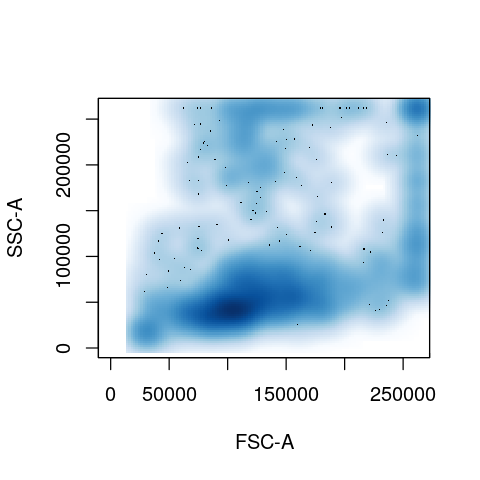

In [4]:
plot(x[1:1000, c(1,4)])

### Load data set into R DataFrame

[Feahtr](http://blog.rstudio.com/2016/03/29/feather/) is a fast storage format for data frames that allows for convenient data exchange between R and Python `pandas`. Given the size of flow and scRNA-seq data files, it is faster than other portable formats.

In [5]:
library(feather)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::exprs()  masks flowCore::exprs()
✖ dplyr::filter() masks flowCore::filter(), stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [6]:
library(viridis)

Loading required package: viridisLite


In [7]:
path <- 'data/flow27parameter_indexed.feather'
df <- read_feather(path)

#### Instpect data set

In [8]:
dim(df)

[1] 10000    30

In [9]:
colnames(df)

[1] "FSC.A"          "SSC.A"          "CD45RA_BB515"   "CD94_BB630"    
 [5] "CD195_BB660"    "CD8_PerCP.Cy55" "CD38_BB790"     "CD127_AF647"   
 [9] "CD56_APCR700"   "HLADR_APCCy7"   "CD32_BUV395"    "CD16_BUV496"   
[13] "CD19_BUV563"    "IgD_BUV615"     "CD4_BUV661"     "CD64_BUV737"   
[17] "CD14_BUV805"    "CD11c_PE"       "CD13_PECF594"   "CD123_PECy5"   
[21] "PE.Cy5_5.A"     "CD25_PECy7"     "CD57_BV421"     "CD3_BV480"     
[25] "BV570.A"        "BV605.A"        "CD15_BV650"     "CD27_BV711"    
[29] "CD20_BV750"     "CD197_BV786"

#### Convert column names to be R friendly

In [10]:
colnames(df) <- make.names(colnames(df))

In [11]:
colnames(df)

[1] "FSC.A"          "SSC.A"          "CD45RA_BB515"   "CD94_BB630"    
 [5] "CD195_BB660"    "CD8_PerCP.Cy55" "CD38_BB790"     "CD127_AF647"   
 [9] "CD56_APCR700"   "HLADR_APCCy7"   "CD32_BUV395"    "CD16_BUV496"   
[13] "CD19_BUV563"    "IgD_BUV615"     "CD4_BUV661"     "CD64_BUV737"   
[17] "CD14_BUV805"    "CD11c_PE"       "CD13_PECF594"   "CD123_PECy5"   
[21] "PE.Cy5_5.A"     "CD25_PECy7"     "CD57_BV421"     "CD3_BV480"     
[25] "BV570.A"        "BV605.A"        "CD15_BV650"     "CD27_BV711"    
[29] "CD20_BV750"     "CD197_BV786"

In [12]:
head(df, n=3)

FSC.A,SSC.A,CD45RA_BB515,CD94_BB630,CD195_BB660,CD8_PerCP.Cy55,CD38_BB790,CD127_AF647,CD56_APCR700,HLADR_APCCy7,⋯,PE.Cy5_5.A,CD25_PECy7,CD57_BV421,CD3_BV480,BV570.A,BV605.A,CD15_BV650,CD27_BV711,CD20_BV750,CD197_BV786
79154.35,5.624549,3.8211818,2.3091235,1.2414309,2.9135091,-0.3884503,0.4055518,2.0170150,1.1613113,⋯,3.344211,0.6801387,1.546033,5.750493,-0.9477741,1.710801,-0.07358696,0.90774632,-0.1815819,-0.3761730
124136.11,7.366415,0.3953270,1.3615631,0.7480631,0.7724101,1.4852096,-0.3258302,0.6746473,0.8343109,⋯,-2.435252,-0.3144020,4.324942,1.553896,1.0916839,2.829710,5.11753654,0.06205167,-0.4385712,0.9617838
124842.20,7.982313,0.4318334,0.2001006,0.5188718,-0.3806170,1.1004614,0.6486881,2.0015900,-0.3130656,⋯,2.452153,0.1767815,4.666556,1.952706,0.4128585,3.192539,5.17661095,0.65093893,-0.6169148,1.2889181


In [13]:
tail(df, n=3)

FSC.A,SSC.A,CD45RA_BB515,CD94_BB630,CD195_BB660,CD8_PerCP.Cy55,CD38_BB790,CD127_AF647,CD56_APCR700,HLADR_APCCy7,⋯,PE.Cy5_5.A,CD25_PECy7,CD57_BV421,CD3_BV480,BV570.A,BV605.A,CD15_BV650,CD27_BV711,CD20_BV750,CD197_BV786
118722.59,7.815092,0.6738266,1.1630605,0.2695481,-0.3761343,1.426748,-1.9248850,3.5698423,0.02724619,⋯,2.643675,-0.5393955,5.081773,0.6878659,-1.2314630,3.4089437,5.9423451,-0.4161369,0.3781908,0.3260019
68959.57,5.486153,5.5829797,0.9087318,-0.2065162,0.1396823,2.561771,2.0639863,-1.4110574,-0.09648702,⋯,-1.857017,0.9108918,2.635946,6.4569082,0.8375989,-0.7982778,0.8290519,3.1861739,0.3039513,1.6742320
121045.34,7.568907,0.2126726,1.3129181,1.1642168,-0.9301268,1.375308,0.7516499,-0.8330962,0.06931397,⋯,3.084723,-0.4733180,4.551968,1.4523821,-0.7098041,3.1914356,5.1785817,0.4184261,0.2184055,-0.2717281


In [14]:
sample_n(df, 3)

FSC.A,SSC.A,CD45RA_BB515,CD94_BB630,CD195_BB660,CD8_PerCP.Cy55,CD38_BB790,CD127_AF647,CD56_APCR700,HLADR_APCCy7,⋯,PE.Cy5_5.A,CD25_PECy7,CD57_BV421,CD3_BV480,BV570.A,BV605.A,CD15_BV650,CD27_BV711,CD20_BV750,CD197_BV786
141946.73,7.779364,1.5440080,1.919609,0.1051243,-0.5328124,1.664032,-0.6549042,-1.3455602,0.8950400,⋯,1.906078,0.2609213,4.709330,1.961062,1.4615284,2.365659,5.314695,0.2509619,0.42037576,-0.6420011
72483.54,5.400058,7.1476574,1.242626,-0.2841934,-0.1594057,2.487665,1.4247898,-1.8998860,0.8290732,⋯,1.262838,-0.0889487,2.449837,5.759773,0.6406636,-1.882274,1.642246,3.2458515,-0.09405882,1.6326449
134843.73,7.365109,0.7618124,1.940849,-0.4206106,0.6504782,1.198363,-0.6949638,0.1579234,1.2519375,⋯,-2.507244,-0.4036633,4.537408,1.235191,-1.3276392,2.584052,5.201757,-0.3781130,0.23864280,0.1754806


#### Piping

In [15]:
df %>% head(10) %>% tail(3)

FSC.A,SSC.A,CD45RA_BB515,CD94_BB630,CD195_BB660,CD8_PerCP.Cy55,CD38_BB790,CD127_AF647,CD56_APCR700,HLADR_APCCy7,⋯,PE.Cy5_5.A,CD25_PECy7,CD57_BV421,CD3_BV480,BV570.A,BV605.A,CD15_BV650,CD27_BV711,CD20_BV750,CD197_BV786
147816.77,7.692855,1.137526,0.1908337,0.6741691,0.1731744,0.8188692,-0.4124186,1.955770,0.9753729,⋯,-1.279034,0.86353821,4.402926,2.239739,0.5127817,2.893812,4.8312922,0.06432857,0.07818439,1.25898933
97029.99,7.632838,1.175190,1.9888933,0.6361272,-0.7015143,1.9020078,-0.9731231,2.502786,0.2125455,⋯,2.804643,0.05957562,4.705359,2.093060,-0.1286883,2.960867,5.4447317,0.31910658,0.27965164,-0.07704708
92332.29,5.912672,6.873731,3.2435505,1.0448424,2.0686421,0.6413540,0.1413259,2.766953,-0.3512652,⋯,4.110049,-0.88639355,6.121744,5.198122,-1.0062705,2.329746,0.2777683,1.16031623,-0.44501862,0.33956066


#### Can split over several lines for readbility

In [16]:
df %>% 
head(10) %>% 
tail(3)

FSC.A,SSC.A,CD45RA_BB515,CD94_BB630,CD195_BB660,CD8_PerCP.Cy55,CD38_BB790,CD127_AF647,CD56_APCR700,HLADR_APCCy7,⋯,PE.Cy5_5.A,CD25_PECy7,CD57_BV421,CD3_BV480,BV570.A,BV605.A,CD15_BV650,CD27_BV711,CD20_BV750,CD197_BV786
147816.77,7.692855,1.137526,0.1908337,0.6741691,0.1731744,0.8188692,-0.4124186,1.955770,0.9753729,⋯,-1.279034,0.86353821,4.402926,2.239739,0.5127817,2.893812,4.8312922,0.06432857,0.07818439,1.25898933
97029.99,7.632838,1.175190,1.9888933,0.6361272,-0.7015143,1.9020078,-0.9731231,2.502786,0.2125455,⋯,2.804643,0.05957562,4.705359,2.093060,-0.1286883,2.960867,5.4447317,0.31910658,0.27965164,-0.07704708
92332.29,5.912672,6.873731,3.2435505,1.0448424,2.0686421,0.6413540,0.1413259,2.766953,-0.3512652,⋯,4.110049,-0.88639355,6.121744,5.198122,-1.0062705,2.329746,0.2777683,1.16031623,-0.44501862,0.33956066


#### To save piped output, re-assign to new variable

In [17]:
x <- df %>% 
head(10) %>% 
tail(3)

In [18]:
x

FSC.A,SSC.A,CD45RA_BB515,CD94_BB630,CD195_BB660,CD8_PerCP.Cy55,CD38_BB790,CD127_AF647,CD56_APCR700,HLADR_APCCy7,⋯,PE.Cy5_5.A,CD25_PECy7,CD57_BV421,CD3_BV480,BV570.A,BV605.A,CD15_BV650,CD27_BV711,CD20_BV750,CD197_BV786
147816.77,7.692855,1.137526,0.1908337,0.6741691,0.1731744,0.8188692,-0.4124186,1.955770,0.9753729,⋯,-1.279034,0.86353821,4.402926,2.239739,0.5127817,2.893812,4.8312922,0.06432857,0.07818439,1.25898933
97029.99,7.632838,1.175190,1.9888933,0.6361272,-0.7015143,1.9020078,-0.9731231,2.502786,0.2125455,⋯,2.804643,0.05957562,4.705359,2.093060,-0.1286883,2.960867,5.4447317,0.31910658,0.27965164,-0.07704708
92332.29,5.912672,6.873731,3.2435505,1.0448424,2.0686421,0.6413540,0.1413259,2.766953,-0.3512652,⋯,4.110049,-0.88639355,6.121744,5.198122,-1.0062705,2.329746,0.2777683,1.16031623,-0.44501862,0.33956066


#### Subsetting data

In [19]:
df[1:3, c(3,4,6)]

CD45RA_BB515,CD94_BB630,CD8_PerCP.Cy55
3.8211818,2.3091235,2.9135091
0.3953270,1.3615631,0.7724101
0.4318334,0.2001006,-0.3806170


#### Selecting columns

In [20]:
df %>% 
select(c('CD4_BUV661', 'CD8_PerCP.Cy55')) %>% 
head(3)

CD4_BUV661,CD8_PerCP.Cy55
0.06071329,2.9135091
1.35243356,0.7724101
0.86341548,-0.3806170


In [21]:
df %>% 
select(starts_with('CD4')) %>% 
head(3)

CD45RA_BB515,CD4_BUV661
3.8211818,0.06071329
0.3953270,1.35243356
0.4318334,0.86341548


In [22]:
df %>% 
select(contains('SC')) %>%
head(3)

FSC.A,SSC.A
79154.35,5.624549
124136.11,7.366415
124842.20,7.982313


#### Filtering rows

In [23]:
dim(df)

[1] 10000    30

In [24]:
colnames(df)

[1] "FSC.A"          "SSC.A"          "CD45RA_BB515"   "CD94_BB630"    
 [5] "CD195_BB660"    "CD8_PerCP.Cy55" "CD38_BB790"     "CD127_AF647"   
 [9] "CD56_APCR700"   "HLADR_APCCy7"   "CD32_BUV395"    "CD16_BUV496"   
[13] "CD19_BUV563"    "IgD_BUV615"     "CD4_BUV661"     "CD64_BUV737"   
[17] "CD14_BUV805"    "CD11c_PE"       "CD13_PECF594"   "CD123_PECy5"   
[21] "PE.Cy5_5.A"     "CD25_PECy7"     "CD57_BV421"     "CD3_BV480"     
[25] "BV570.A"        "BV605.A"        "CD15_BV650"     "CD27_BV711"    
[29] "CD20_BV750"     "CD197_BV786"

In [25]:
dim(df)

[1] 10000    30

In [26]:
df %>% 
filter(FSC.A > 50000) %>%
dim

[1] 9674   30

#### DIY rectangular gating

In [27]:
df %>% 
filter(FSC.A > 50000, 
       FSC.A < 250000,
       CD3_BV480 > quantile(CD3_BV480, 0.5)) %>%
dim

[1] 4797   30

#### Mutating data

`mutate` returns original and transformed columns

In [28]:
df %>% 
select(contains('SC')) %>% 
mutate(FSC.SC = scale(FSC.A),
          SSC.SC = scale(SSC.A)) %>%
head(3)

FSC.A,SSC.A,FSC.SC,SSC.SC
79154.35,5.624549,-0.6105343,-1.147803
124136.11,7.366415,0.5503980,0.587082
124842.20,7.982313,0.5686216,1.200512


`transmute` only returns transformed columns

In [29]:
df %>% 
transmute(FSC.SC = scale(FSC.A),
          SSC.SC = scale(SSC.A)) %>%
head(3)

FSC.SC,SSC.SC
-0.6105343,-1.147803
0.5503980,0.587082
0.5686216,1.200512


#### Summarizing data

In [30]:
df %>%
summarize_if(is.numeric, median)

FSC.A,SSC.A,CD45RA_BB515,CD94_BB630,CD195_BB660,CD8_PerCP.Cy55,CD38_BB790,CD127_AF647,CD56_APCR700,HLADR_APCCy7,⋯,PE.Cy5_5.A,CD25_PECy7,CD57_BV421,CD3_BV480,BV570.A,BV605.A,CD15_BV650,CD27_BV711,CD20_BV750,CD197_BV786
97140.16,7.345209,1.38829,1.319535,0.3619756,0.172222,1.282351,0.3663073,1.545928,0.4983937,⋯,0.07914941,0.343787,4.429566,1.991104,0.355557,2.041021,4.73033,0.115984,0.04964578,0.796197


In [31]:
df %>%
select(starts_with('CD4')) %>% 
summarize_all(funs(min, max))

CD45RA_BB515_min,CD4_BUV661_min,CD45RA_BB515_max,CD4_BUV661_max
-3.297107,-6.160768,8.301044,5.614415


### Simple visualizationm

In [32]:
n <- 10000
sc <- df %>% 
sample_n(n, replace = FALSE) %>%
select(contains('SC'))

In [33]:
sc %>% head(n=3)

FSC.A,SSC.A
87076.48,5.733697
81665.36,5.566556
70142.15,5.413549


In [34]:
options(repr.plot.width = 10, repr.plot.height = 4)

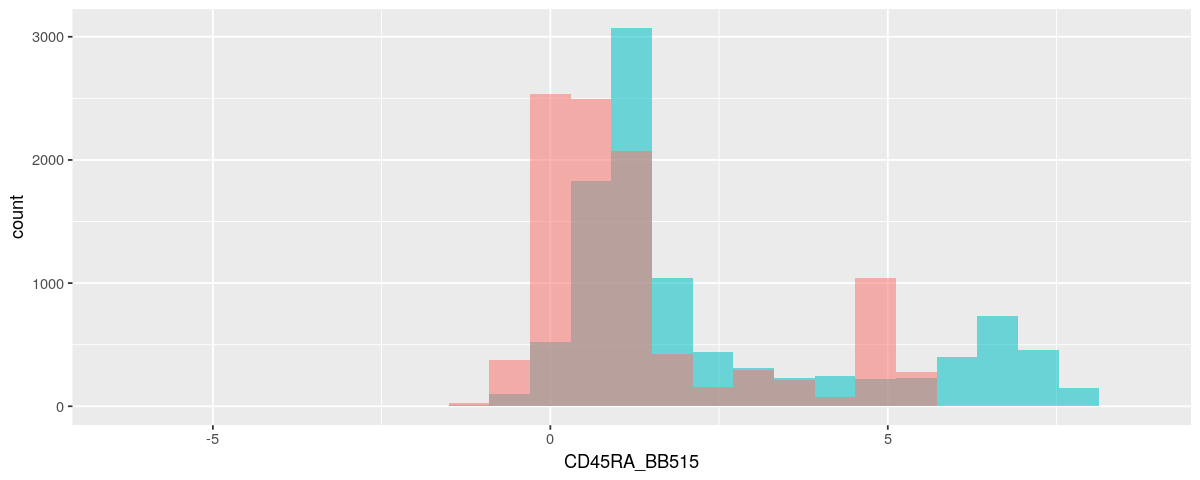

In [35]:
ggplot(df) +
geom_histogram(bins = 25, aes(x=CD45RA_BB515, alpha=0.2, fill="red")) +
geom_histogram(bins = 25, aes(x=CD4_BUV661, alpha=0.2, fill="green")) +
guides(alpha=FALSE, fill=FALSE)

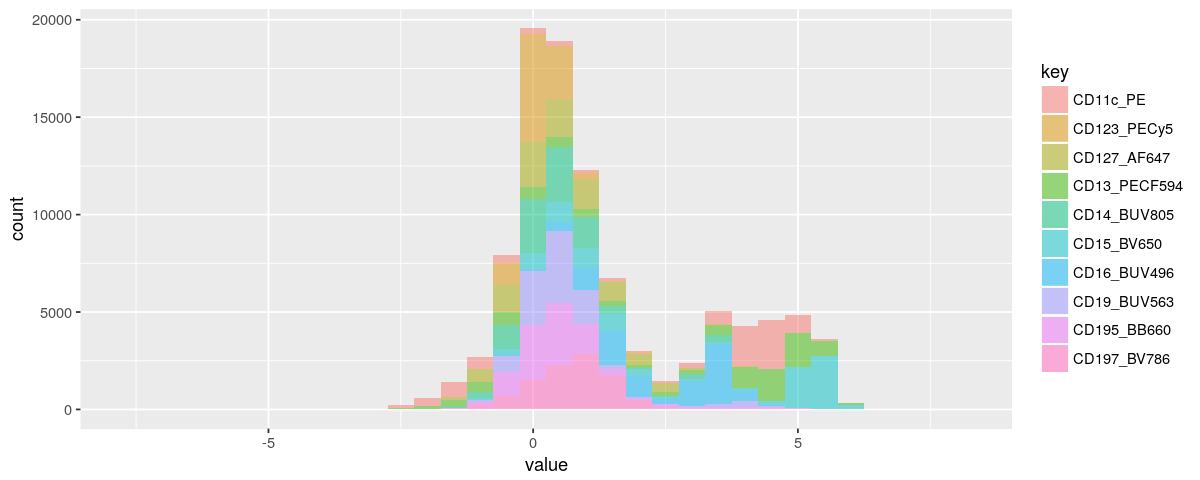

In [36]:
df %>% 
select(starts_with('CD1')) %>% 
gather  %>%
ggplot(aes(x=value, fill=key)) + 
geom_histogram(binwidth=0.5, alpha=0.5) + 
guides(alpha=FALSE)

In [37]:
options(repr.plot.width = 4, repr.plot.height = 4)

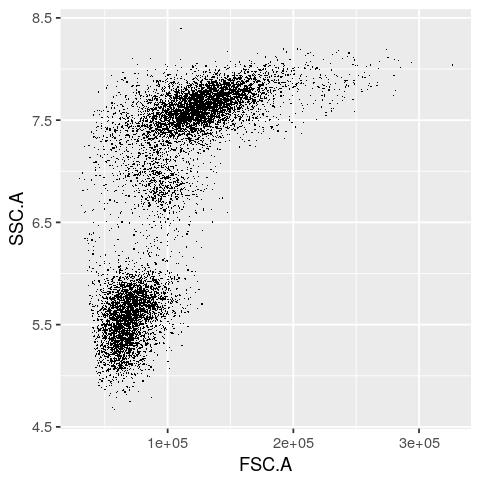

In [38]:
ggplot(sc, aes(x=FSC.A, y=SSC.A)) +
geom_point(shape='.')

[Original source for get_density function](http://slowkow.com/notes/ggplot2-color-by-density/)

In [39]:
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

In [40]:
d <- get_density(sc$FSC.A, sc$SSC.A)

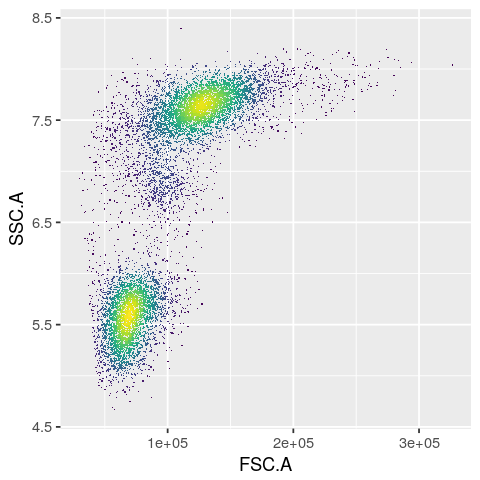

In [41]:
ggplot(sc, aes(x=FSC.A, y=SSC.A, color=d)) +
geom_point(shape='.') +
scale_color_viridis() +
guides(color=FALSE)

In [42]:
colnames(df)

[1] "FSC.A"          "SSC.A"          "CD45RA_BB515"   "CD94_BB630"    
 [5] "CD195_BB660"    "CD8_PerCP.Cy55" "CD38_BB790"     "CD127_AF647"   
 [9] "CD56_APCR700"   "HLADR_APCCy7"   "CD32_BUV395"    "CD16_BUV496"   
[13] "CD19_BUV563"    "IgD_BUV615"     "CD4_BUV661"     "CD64_BUV737"   
[17] "CD14_BUV805"    "CD11c_PE"       "CD13_PECF594"   "CD123_PECy5"   
[21] "PE.Cy5_5.A"     "CD25_PECy7"     "CD57_BV421"     "CD3_BV480"     
[25] "BV570.A"        "BV605.A"        "CD15_BV650"     "CD27_BV711"    
[29] "CD20_BV750"     "CD197_BV786"

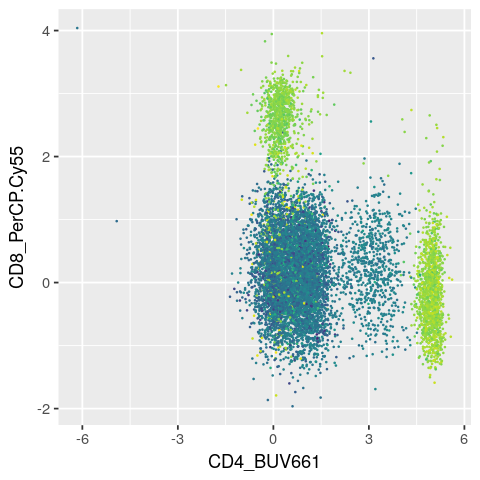

In [43]:
ggplot(df,
       aes(x=CD4_BUV661, y=CD8_PerCP.Cy55, 
           color=df$CD3_BV480)) +
geom_point(size=0.1) +
scale_color_viridis() +
guides(color=FALSE)

#### Make some subsampled data and save to file

In [44]:
for (i in 1:3) {
    path <- paste('data', 
                      paste('xs', i, '.feather', sep=''),
                      sep='/')
    data <- sample_n(df, 10000, replace=FALSE)
    write_feather(data, path)
}

In [45]:
list.files('data', 'xs.*feather')

[1] "xs1.feather" "xs2.feather" "xs3.feather"